In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt 
%matplotlib inline
import os
import tensorflow as tf
import cv2
from tensorflow.keras.callbacks import EarlyStopping
import glob
import splitfolders 
import numpy as np

In [3]:
input_dir = 'simpson_dataset\simpsons_dataset'
output_dir = "./simpon_data"

#Split the data into train and valid folders
#splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.9, 0.1)) 

In [4]:
train_dir = "./simpson_family_data/train"
val_dir = "./simpson_family_data/val"


# dimensions of our images.
image_size = (90, 90, 3)
# number of epochs to train top model 
epochs = 20 
# batch size used by flow_from_directory and predict_generator 
batch_size = 32

#characters for classification 
labels = os.listdir(train_dir)
print(labels)

['bart_simpson', 'homer_simpson', 'lisa_simpson', 'maggie_simpson', 'marge_simpson']


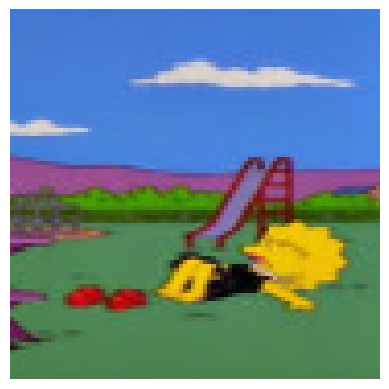

In [5]:
image_name = train_dir +"/lisa_simpson/pic_0010.jpg" #Image to be used as query
def plotLisa(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (90,90))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotLisa(image_name)

Preprocessing data for training models involves creating additional copies of each image with various effects. During the preparation of training data, images undergo rescaling, flipping, rotation, and shifting to enhance diversity and improve model robustness. For validation data, images are solely rescaled to ensure accurate performance evaluation.

In [6]:
train_datagen = ImageDataGenerator( rescale = 1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2
                                    )

test_datagen = ImageDataGenerator(rescale = 1./255)
training_set =  train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=image_size[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb'

)

val_set =  test_datagen.flow_from_directory(
                                                    val_dir,
                                                    target_size=image_size[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=False

)

Found 5722 images belonging to 5 classes.
Found 639 images belonging to 5 classes.


Now i implemented a Convolutional Neural Network (CNN) using the Keras Sequential API. It consists of three sets of convolutional layers with max-pooling and dropout for feature extraction. The model is then flattened and connected to two dense layers, with ReLU activation in the hidden layer and softmax in the output layer for multi-class classification.

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=image_size, activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation="relu")) 
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))

In [84]:
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

Now i include an EarlyStopping callback, which halts training if the validation accuracy does not improve for five consecutive epochs, preventing potential overfitting. Additionally, there's a ModelCheckpoint callback that saves the model's weights to "./simpson_model.h5" only when the validation accuracy is maximized, ensuring the preservation of the best-performing model. 

In [85]:
checkpoint_filepath = "./simpson_model.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
             EarlyStopping(patience=5, monitor="val_accuracy", mode="max"),
             model_checkpoint_callback,
]

NameError: name 'checkpoint_filepath' is not defined

Training the model

In [86]:
history = model.fit(  training_set,
                                epochs=epochs,
                                validation_data=val_set,
                                callbacks = callbacks
)

NameError: name 'callbacks' is not defined

Loading the model to test it.

In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
model = load_model('simpson_model.h5')

now I make a classification report

In [8]:
val_predictions = model.predict(val_set)

val_pred_labels = [np.argmax(pred) for pred in val_predictions]

val_true_labels = val_set.classes

report = classification_report(val_true_labels, val_pred_labels , target_names = labels)

print("\nClassification Report:")
print(report)


20/20 [==============================] - 7s 311ms/step

Classification Report:
                precision    recall  f1-score   support

  bart_simpson       0.96      0.84      0.90       135
 homer_simpson       0.95      0.97      0.96       225
  lisa_simpson       0.89      0.96      0.92       136
maggie_simpson       0.80      0.62      0.70        13
 marge_simpson       0.96      0.98      0.97       130

      accuracy                           0.94       639
     macro avg       0.91      0.87      0.89       639
  weighted avg       0.94      0.94      0.94       639




The training process yielded exceptional results, showcasing an impressive 94% accuracy. Each character achieved a precision rate of over 95%, with the exception of Maggie and Lisa, who displayed slightly lower precision levels, possibly due to their striking similarities. The model encountered challenges in accurately classifying these two characters.

i created a function that receive an image and predict which character is using the model

In [9]:
characters = ['Bart' , 'Homer' , 'Lisa' , 'Maggie' , 'Marge']

def predict(img):
    img_batch = np.expand_dims(img, axis=0)
    prediction = model.predict(img_batch)
    precision = max(max(prediction))
    prediction = characters[np.argmax(prediction)]
    return prediction , precision

a small example of how the model is working in a data validation image.

1/1 [==============================] - 0s 332ms/step


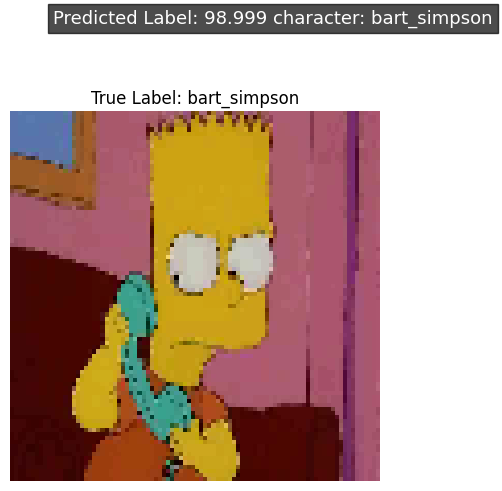

In [10]:
batch_images, batch_labels = next(val_set)
first_image = batch_images[0]

# Convert from normalized form back to the original scale (if you applied rescaling during data augmentation)
first_image_original_scale = first_image * 255.0

# Display the image using matplotlib
plt.imshow(first_image_original_scale.astype('uint8'))  
plt.title(f"True Label: {labels[np.argmax(batch_labels[0])]}")

img_array = first_image
 
img_batch = np.expand_dims(img_array, axis=0)  
predictions = model.predict(img_batch)
character = labels[np.argmax(predictions)]
predicted_character = np.max(np.max(predictions))
predicted_character = round(predicted_character*100, 3)

plt.text(10, -22, f'Predicted Label: {str(predicted_character)}' + f' character: {character}' , color='white', fontsize=13, bbox=dict(facecolor='black', alpha=0.7))
plt.axis('off')
plt.show()

Now, look at how it worked for each character with images that were not in the data used to train the model.

In [11]:
def plot_func(image_location, ax):
    imagen = cv2.imread(image_location)
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    compressed_image = cv2.resize(imagen, (90,90))  / 255.0
    character , precision = predict(compressed_image)
    ax.imshow(imagen)
    ax.text(10, 10, f' {str(character)}' + f' Prec: {str(round(precision*100,3))}%' , color='white', bbox=dict(facecolor='black', alpha=0.7))
    ax.axis('off')

In [12]:
test_dir = "test/images/"
bart_1 = test_dir + "bart_1.jpg"
bart_2 = test_dir + "bart_2.jpg"

homer_1 = test_dir +"homer_1.jpg"
homer_2 = test_dir + "homer_2.jpg"

lisa_1 = test_dir + "lisa_1.jpg"
lisa_2 = test_dir + "lisa_2.jpg"

maggie_1 = test_dir + "maggie_1.jpg"
maggie_2 = test_dir + "maggie_2.jpg"

marge_1 =  test_dir + "marge_1.jpg"
marge_2 = test_dir + "marge_2.jpg"


1/1 [==============================] - 0s 114ms/step


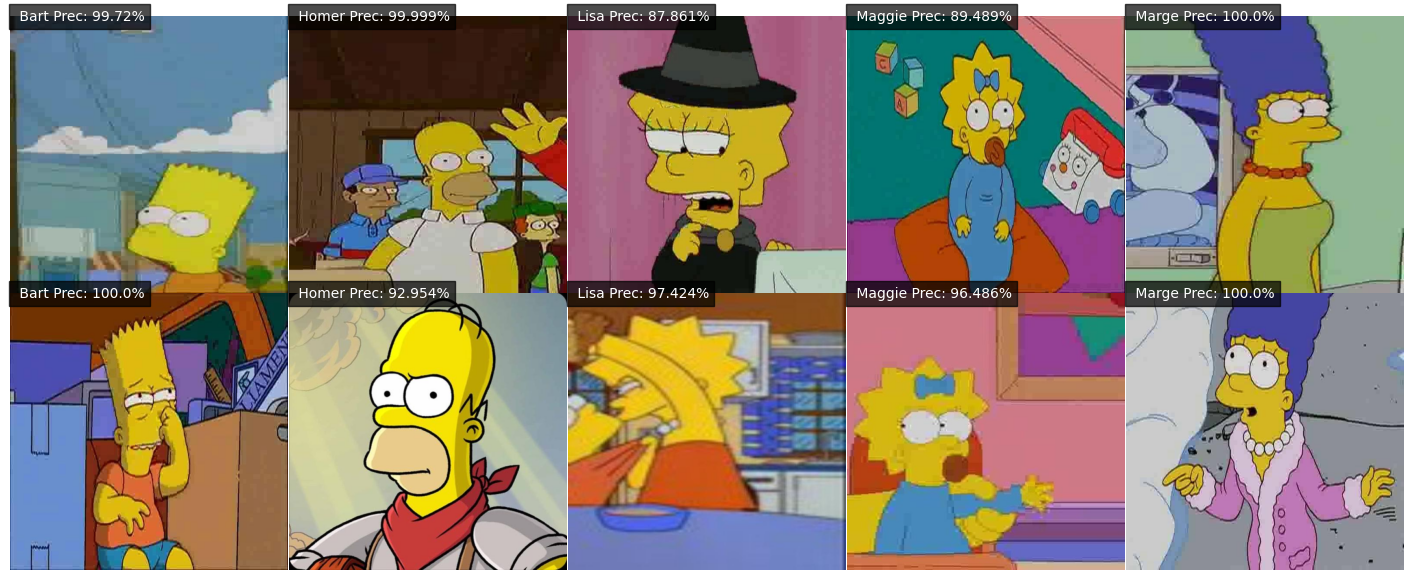

<Figure size 640x480 with 0 Axes>

In [13]:
fig, axs = plt.subplots(2, 5, figsize=(18, 7.2))
plt.subplots_adjust(wspace=0, hspace=0 )
for ax in axs.flat:
    ax.axis('off')

plot_func(bart_1 , axs[0,0])
plot_func(bart_2 , axs[1,0])

plot_func(homer_1 , axs[0,1])
plot_func(homer_2 , axs[1,1])

plot_func(lisa_1 , axs[0,2])
plot_func(lisa_2 , axs[1,2])

plot_func(maggie_1 , axs[0,3])
plot_func(maggie_2 , axs[1,3])

plot_func(marge_1 , axs[0,4])
plot_func(marge_2 , axs[1,4])

plt.show()
plt.savefig('simpson_classification.jpg')

Now that we're observing, the model performs exceptionally well. However, it's important to note that no model can guarantee 100% security. Let's examine the three elements with lower accuracy and explore the probabilities assigned to other characters.

In [14]:
def predict_all(img):
    img_batch = np.expand_dims(img, axis=0)
    prediction = model.predict(img_batch)
    dict = {}
    for i in range(len(characters)):
        dict[characters[i]] = round(prediction[0][i]*100,3)
    return dict

In [19]:
def plot_func_all_characters(image_location, ax):
    imagen = cv2.imread(image_location)
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    compressed_image = cv2.resize(imagen, (90,90))  / 255.0
    predictions_dict  = predict_all(compressed_image)
    predictions_dict_ord = dict(sorted(predictions_dict.items(), key=lambda x: x[1], reverse=True))
    ax.imshow(imagen)
    
    text_content = '% \n'.join([f'{key}: {str(value)}' for key, value in predictions_dict_ord.items()])
    ax.text(0.35, 0.05, text_content, fontsize=10, transform=ax.transAxes, ha='right' , color = 'white' , bbox=dict(facecolor='black', alpha=0.7))
    ax.axis('off')

1/1 [==============================] - 0s 94ms/step


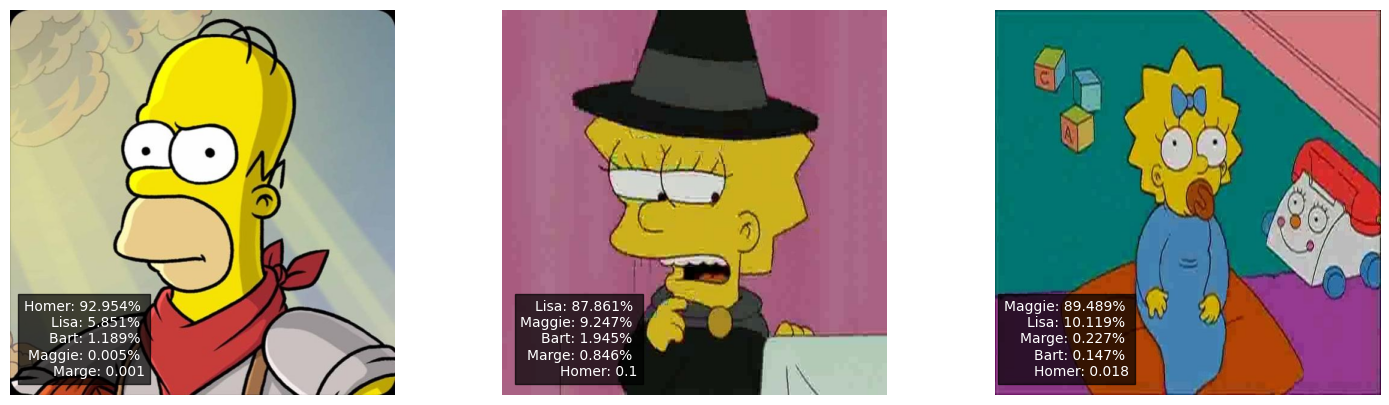

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

plot_func_all_characters(homer_2 , axs[0])
plot_func_all_characters(lisa_1 , axs[1])
plot_func_all_characters(maggie_1 , axs[2])

Now, as mentioned earlier, the model encounters more challenges when trying to classify between Lisa and Maggie due to their physical similarities. It is comparatively easier for the model to correctly discriminate among other characters.

In this project, it is evident that achieving a high accuracy rate to distinguish between Simpsons characters is indeed possible.

## Conclusion

In this project, achieving a high accuracy rate to distinguish between Simpsons characters is indeed feasible. However, certain limitations exist. For instance, in our dataset, each image corresponds to only one character. What if an image contains two characters? The model may struggle to discriminate accurately because the training data did not include instances with more than one label per image. This is a classification model, not a computer vision model that can detect and classify multiple characters within a single image. For that purpose, we are currently implementing YOLO in Project Number 2.